In [1]:
from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_vqe import CutVQE
from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_qaoa import CutQAOA

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

algorithm_globals.random_seed = 123
seed = 10598

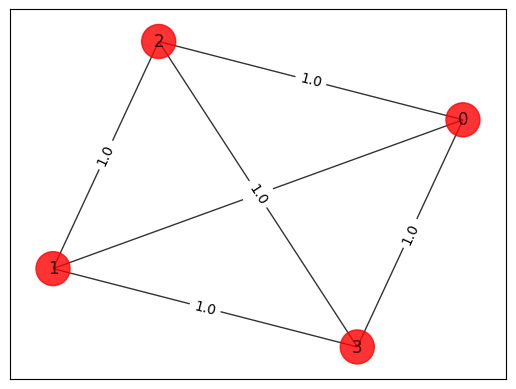

In [3]:
n = 4 # number of nodes in the graph
G = nx.random_regular_graph(3, n)

for (u,v) in G.edges():
    G[u][v]['weight'] = 1.0

pos = nx.spring_layout(G)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [5]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
#print(qp.prettyprint())
qubitOp, offset = qp.to_ising()
#print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZIZI
+ 0.5 * ZZII


/tmp/ipykernel_144/2743655176.py:8: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(optimizer=optimizer, reps=1, quantum_instance=backend)
/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


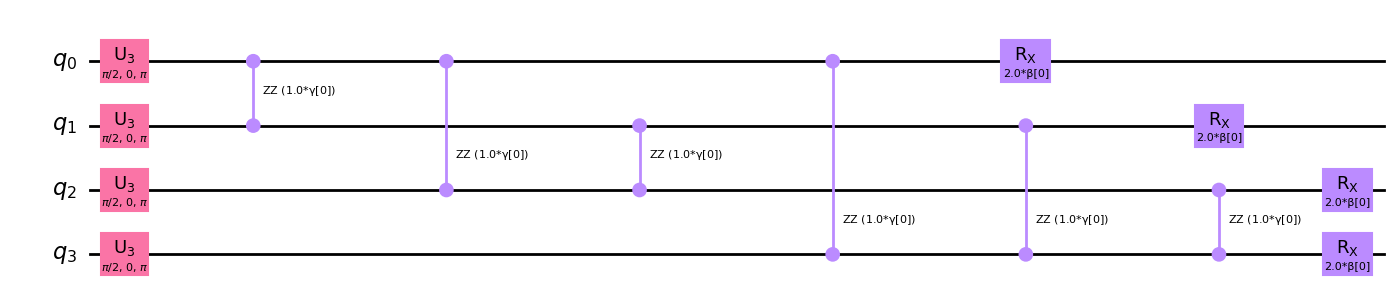

In [6]:
from qiskit.algorithms import QAOA
from qiskit import Aer

optimizer = SPSA(maxiter=300)
backend = Aer.get_backend('aer_simulator')

# Change the number of reps if desired
qaoa = QAOA(optimizer=optimizer, reps=1, quantum_instance=backend)
qaoa_result = qaoa.compute_minimum_eigenvalue(qubitOp)
qaoa.ansatz.decompose(reps=2).draw('mpl')

energy: -0.7392578125
time: 2.0634360313415527
max-cut objective: -3.7392578125
solution: [1 1 0 0]
solution objective: 4.0


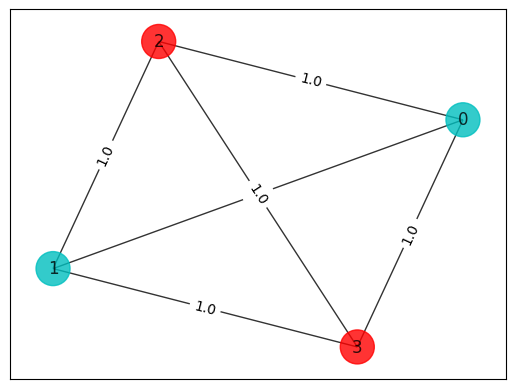

In [7]:
# print results
x = max_cut.sample_most_likely(qaoa_result.eigenstate)
print("energy:", qaoa_result.eigenvalue.real)
print("time:", qaoa_result.optimizer_time)
print("max-cut objective:", qaoa_result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

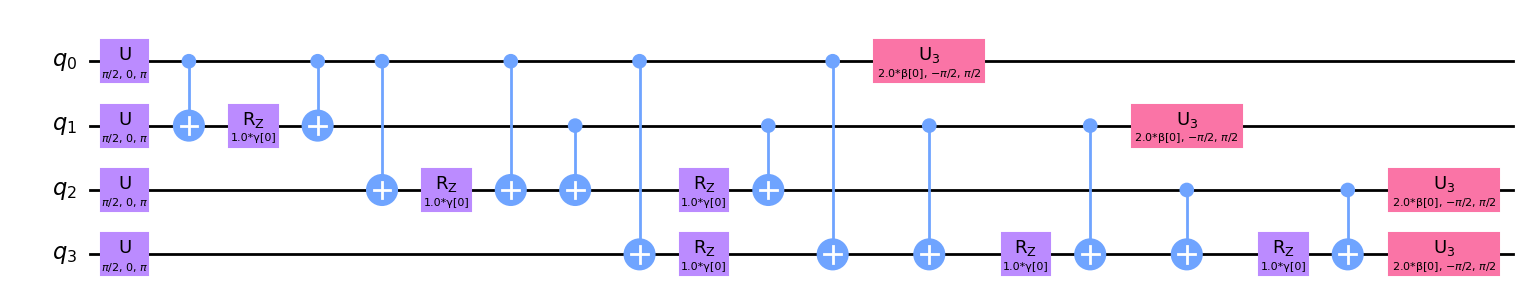

In [100]:
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz

ansatz = QAOAAnsatz(qubitOp, reps=1, flatten=True)
ansatz.decompose(reps=3).draw('mpl')

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


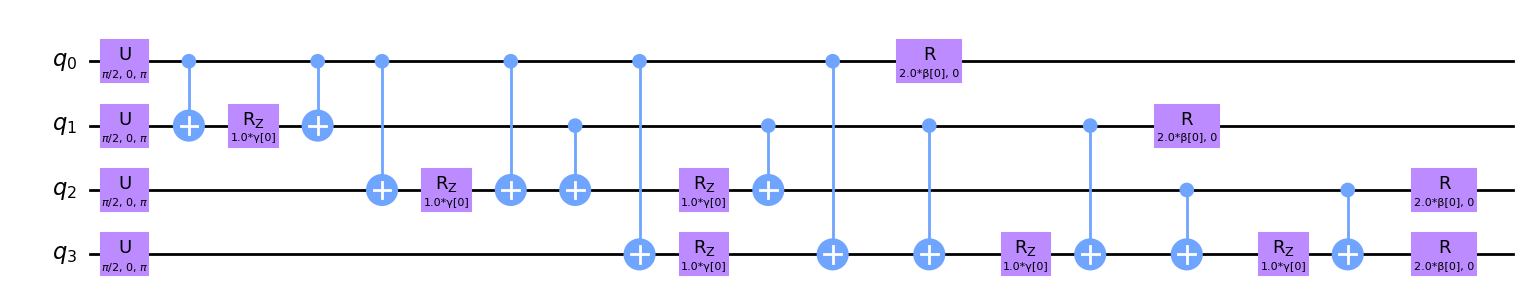

In [9]:
# Convert the NLocal ansatz type to QuantumCircuit and decompose 4 times to remove RZZ gates
from qiskit import QuantumCircuit

qc = QuantumCircuit(4)
qc &= ansatz.decompose(reps=4)
qc.draw('mpl')

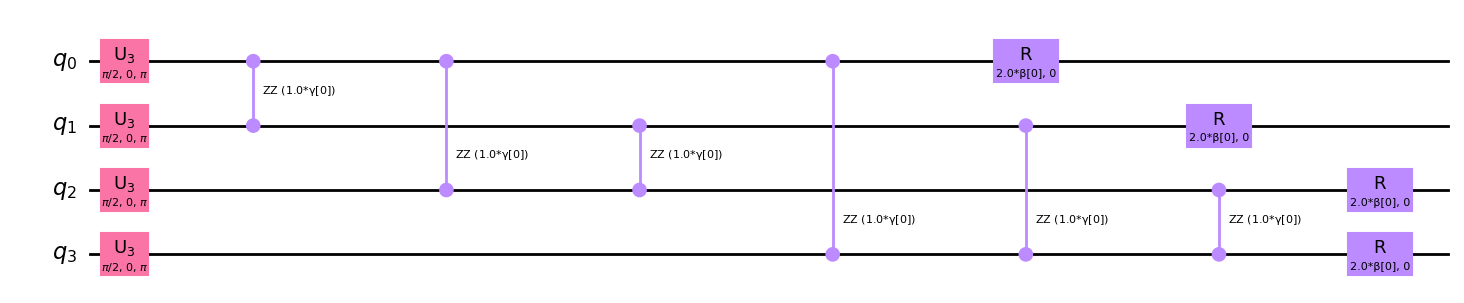

In [64]:
ansatz.decompose(reps=2).draw('mpl')

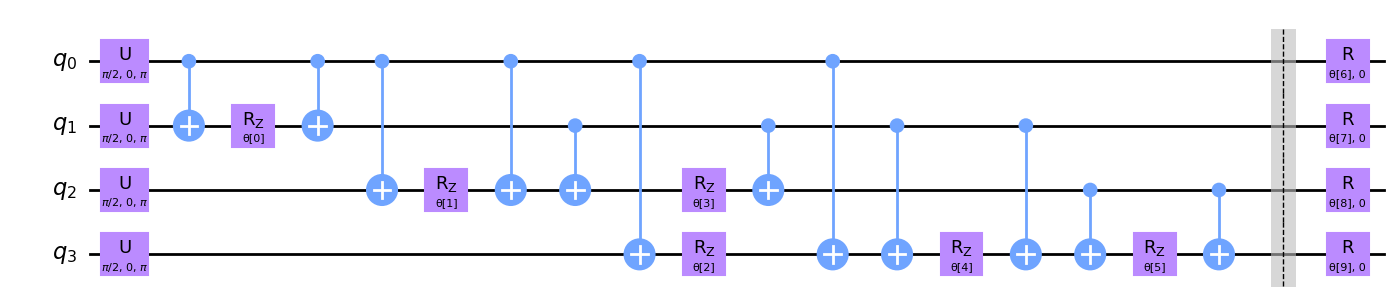

In [113]:
qaoa_qc = QuantumCircuit(4)
for i in range(0,n):
    qaoa_qc.u(np.pi/2, 0, np.pi, i)

from qiskit.circuit import ParameterVector
import math

theta = ParameterVector("θ", int(math.factorial(n)/n) + n) # for n = 4, len(theta) = 10

k = 0
for i in range(0,n):
    for j in range(i,n):
        if i != j:
            qaoa_qc.rzz(theta[k], i, j)
            k+=1

qaoa_qc.barrier()

for i in range(0, n):
    qaoa_qc.rx(theta[k+i], i)
    
qaoa_qc = qaoa_qc.decompose()
qaoa_qc.draw('mpl')

In [106]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import PauliList
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
    
def callback(eval_count, parameters, mean, std):
    print(f"Round num: {eval_count}, energy: {mean}, parameters: {parameters}")

estimator = Estimator()

# from our qubitOp
observables = PauliList(['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'])

# Cut QAOA result
cut_qaoa = CutQAOA(estimator, ansatz=qaoa_qc, optimizer=optimizer, observables=observables, shots=2**12, max_subcircuit_width=2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 313 rows, 135 columns and 1054 nonzeros
Model fingerprint: 0x5551f746
Variable types: 0 continuous, 135 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 313 rows and 135 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 8 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%
MIP MODEL CU

In [107]:
cut_qaoa_result = cut_qaoa.compute_minimum_eigenvalue(qubitOp)


Round num: 1, energy: 18.721064013004305, parameters: [-5.13260236  3.36114602 -0.29516912 -0.32525928 -0.07069824  3.44340169
  5.43349625 -4.8686273  -3.23372914  2.2726234 ]


KeyboardInterrupt: 